In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf#Tensorflow framework is used to partition data sets
from sklearn.metrics import mean_squared_error, r2_score
from LSSVMRegression import LSSVMRegression

In [10]:
data = pd.read_excel('D:/LIBS实验数据/LIBS/LIBS/mineral_data/make_data-500-6.5.xlsx')#This is the location of the dataset
x_data = data.iloc[:, 0:4]   #Partition data set
y_data = data.iloc[:, 4]
x_data=np.array(x_data)
y_data=np.array(y_data)
#数据集乱序

np.random.seed(116)
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)

tf.random.set_seed(116)
#将打乱后的数据分为训练集和测试集
x_train = x_data[:-50]
y_train = y_data[:-50]
#y_train = y_train.reshape(1, -1).T
x_test = x_data[-50:]
y_test = y_data[-50:]
X = x_train
Y = y_train
#y_test = y_test.reshape(1, -1).T
#转换数据类型
#x_train = tf.cast(x_train,tf.float32)
#X = tf.cast(x_train,tf.float32)

#y_train = tf.cast(y_train,tf.float32)
#Y = tf.cast(y_train,tf.float32)

In [11]:
#Annotation language is Chinese
#Define the main function that optimizes a given function
def MFO(nsa, dim, ub, lb, max_iter, fobj):
# def MFO(nsa, dim, ub, lb, shift, max_iter, fobj):
    ''' Main function
    Parameters :
    - nsa : Number of Search Agents
    - dim : Dimension of Search Space
    - ub : Upper Bound
    - lb : Lower Bound
    - max_iter : Number of Iterations
    - fobj : Objective Function (Fitness Function)
    Returns :
    - bFlameScore : Best Flame Score   最好的结果得分
    - bFlamePos : Best Flame Position  最好的结果
    - ConvergenceCurve : Evolution of the best Flame Score on every iteration
    '''
    #record_mothPos  所有飞蛾位置
    #record_fitness  每轮迭代的所有适应度
    #record_bmothPos 每一轮的最佳位置

    # Initialize the positions of moths
    mothPos = np.random.uniform(low=lb, high=ub, size=(nsa, dim))  # + np.ones((nsa, dim))*shift   初始化飞蛾位置

    convergenceCurve = np.zeros(shape=(max_iter))#保存每一次迭代过程中最优火焰的得分

    # print("Optimizing  \"" + fobj.__name__ + "\"")
    ###########################################
    record_bmothPos = np.array([])#每轮最佳飞蛾位置   横着显示坐标
    record_mothPos = np.array([[0,0]])#所有飞蛾位置
    record_fitness = np.array([])#所有飞蛾适应度
    ###########################################
    for iteration in range(max_iter):  # Main loop
        # Number of flames Eq. (3.14) in the paper
        flameNo = int(np.ceil(nsa-(iteration+1)*((nsa-1)/max_iter)))#随着迭代，火焰数量减少  np.ceil向上取整

        # Check if moths go out of the search space and bring them back
        mothPos = np.clip(mothPos, lb, ub)#限定飞蛾位置，所有比lb小的值都会被限定成lb
        ###########################################
        record_mothPos = np.append(record_mothPos,values=mothPos,axis=0)#记录所有飞蛾位置
        ###########################################
        # Calculate the fitness of moths
        #mothFit = fobj(mothPos)#将飞蛾位置带入
        fitness_container=[]
        for k in range(0,nsa):#nsa为飞蛾个数
            fitness_container.append(fobj(mothPos[k]))#存入所有飞蛾适应度，fobj为适应度函数
        
        
        mothFit=np.array(fitness_container)
        ###########################################
        record_fitness = np.append(record_fitness,values=mothFit,axis=0)#记录所有飞蛾适应度()
        ###########################################
       
        #记录每轮迭代的所有适应度

        if iteration == 0:#第一次迭代，火焰的位置就是最优适应度飞蛾的位置，火焰适应度等于最优飞蛾适应度
            # Sort the first population of moths
            
            
            order = mothFit.argsort(axis=0)#从小到大排序，返回其索引
            mothFit = mothFit[order]#将适应度从小到大排序
            mothPos = mothPos[order, :]#将飞蛾位置按适应度从小到大排序

            # Update the flames
            bFlames = np.copy(mothPos)#火焰保存了飞蛾排序后的位置
            bFlamesFit = np.copy(mothFit)#火焰适应度保存了飞蛾排序后的适应度

            

        else:
            # Sort the moths
            #record_fitness = np.append(record_fitness,values=mothFit, axis=0)#记录所有飞蛾适应度
            
            doublePop = np.vstack((bFlames, mothPos))#按行堆叠数组
            doubleFit = np.hstack((bFlamesFit, mothFit))#按列堆叠

            order = doubleFit.argsort(axis=0)#将飞蛾和火焰的适应度进行排序，返回其索引
            doubleFit = doubleFit[order]
            doublePop = doublePop[order, :]

            # Update the flames
            bFlames = doublePop[:nsa, :]
            bFlamesFit = doubleFit[:nsa]

        # Update the position best flame obtained so far
        bFlameScore = bFlamesFit[0]#记录最优适应度
        bFlamesPos = bFlames[0, :]#记录最优适应度的飞蛾位置
        ###########################################
        record_bmothPos = np.append(record_bmothPos,values=bFlamesPos,axis=0)#记录每轮迭代中最优的飞蛾位置
        ###########################################
       
        # a linearly dicreases from -1 to -2 to calculate t in Eq. (3.12)  a对应论文中的r
        a = -1 + (iteration+1) * ((-1)/max_iter)#a的范围为-1到-2

        # D in Eq. (3.13)
        distanceToFlames = np.abs(bFlames - mothPos)#飞蛾和火焰的距离

        b = 1
        t = (a-1)*np.random.rand(nsa, dim) + 1#nsa行dim列的矩阵
        ''' Update the position of the moth with respect to its corresponding
        flame if the moth position is less than the number of flames
        calculated, otherwise update the position of the moth with respect
        to the last flame '''#如果飞蛾位置小于计算的火焰数，则更新飞蛾相对于其相应火焰的位置，否则更新飞蛾关于最后一个火焰的位置
        temp1 = bFlames[:flameNo, :]
        temp2 = bFlames[flameNo-1, :]*np.ones(shape=(nsa-flameNo, dim))
        temp2 = np.vstack((temp1, temp2))#np.vstack按行顺序堆叠数组   火焰数目在减少，用适应度最差的火焰补齐火焰位置矩阵
        mothPos = distanceToFlames*np.exp(b*t)*np.cos(t*2*np.pi) + temp2#飞蛾位置更新

        convergenceCurve[iteration] = bFlameScore#保存每一次迭代过程中最优火焰的得分   将每次迭代的最优火焰得分都保存在这个矩阵里

    #return bFlameScore,bFlamesPos,convergenceCurve,record_mothPos,record_fitness,record_bmothPos#convergenceCurve每次迭代的最优适应度
    return convergenceCurve, record_mothPos, record_bmothPos ,record_fitness #convergenceCurve每次迭代的最优适应度

In [12]:
from sklearn.metrics import mean_absolute_error   #Customized fitness function, where the MAE value predicted by the model is used
def fitness_function(position):   # 输出
    clfrbf = LSSVMRegression(gamma=position[0],kernel='rbf',sigma=position[1])
    clfrbf.fit(X,Y) # train our model, aka solve the set of linear equations
    Y_pred = clfrbf.predict(X)
    #print("b = ",clfrbf.intercept_)#截距
    #print("a_i = ",clfrbf.coef_)#支持向量的系数
    MAE=mean_absolute_error(Y_pred, Y)
    # 返回混淆函数，分类误差矩阵，分别是训练中的 测试中的 下面输出错误分类结果
    return MAE

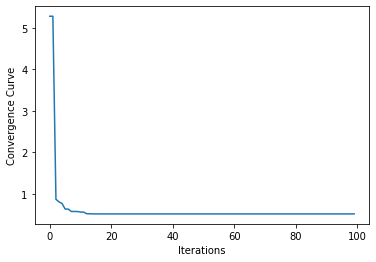

In [13]:
#Testing the optimization function
nsa = 30
max_iter = 100

lb = 0.001
ub = 100
dim = 2
# shift = -30

convergenceCurve, record_mothPos, record_bmothPos ,record_fitness= MFO(
    nsa, dim, ub, lb, max_iter,fitness_function)
#print(bFlameScore, '\n', bFlamesPos)
x = np.arange(0, convergenceCurve.shape[0], 1)#每次迭代都有一个最优适应度
plt.plot(x, convergenceCurve)
plt.xlabel('Iterations')
plt.ylabel('Convergence Curve')
plt.show()

In [14]:
#将所有飞蛾位置写入excel
record_mothPos1 = pd.DataFrame(record_mothPos[:,0])
record_mothPos2 = pd.DataFrame(record_mothPos[:,1])
record_mothPos3 = pd.concat([record_mothPos1,record_mothPos2],axis=1)
writer = pd.ExcelWriter("D:/LIBS实验数据/LIBS/LIBS/mineral_data/MFO所有飞蛾位置-6.5.xlsx")
record_mothPos3.to_excel(writer, 'page_1', float_format='%.5f')
writer.save()
writer.close()
print('OK')

OK


In [15]:
#将每轮最佳飞蛾位置写入excel
record_bmothPos1 = []
record_bmothPos2 = []
for i in range(0,200,2):#(0,102,2)
    record_bmothPos1.append(record_bmothPos[i].tolist())
record_bmothPos1 = pd.DataFrame(record_bmothPos1)
for j in range(1,199,2):#(1,100,2)
    record_bmothPos2.append(record_bmothPos[j].tolist())
record_bmothPos2 = pd.DataFrame(record_bmothPos2)
record_bmothPos3 = pd.concat([record_bmothPos1,record_bmothPos2],axis=1)
writer = pd.ExcelWriter("D:/LIBS实验数据/LIBS/LIBS/mineral_data/MFO每轮最佳飞蛾位置-6.5.xlsx")
record_bmothPos3.to_excel(writer, 'page_1', float_format='%.5f')
writer.save()
writer.close()
print('OK')

OK


In [16]:
#将所有飞蛾适应度写入excel
record_fitness = pd.DataFrame(record_fitness)
writer = pd.ExcelWriter("D:/LIBS实验数据/LIBS/LIBS/mineral_data/MFO所有飞蛾适应度-6.5.xlsx")
record_fitness.to_excel(writer, 'page_1', float_format='%.5f')
writer.save()
writer.close()
print('OK')

OK


In [17]:
#将每轮最佳适应度写入excel
quzaoqian=convergenceCurve
quzaoqian=pd.DataFrame(quzaoqian)
writer = pd.ExcelWriter("D:/LIBS实验数据/LIBS/LIBS/mineral_data/MFO每轮最佳适应度-6.5.xlsx")
quzaoqian.to_excel(writer, 'page_1', float_format='%.5f')
writer.save()
writer.close()
print('OK')

OK
